In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras import layers

import numpy as np
import matplotlib.pyplot as plt
from IPython import display

In [2]:
print(tf.__version__)
for device in tf.config.list_physical_devices():
    print(device)

2.7.0
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [3]:
(trainX, trainy), (testX, testy) = fashion_mnist.load_data()

print("Train :", trainX.shape, trainy.shape)
print("Test :", testX.shape, testy.shape)

Train : (60000, 28, 28) (60000,)
Test : (10000, 28, 28) (10000,)


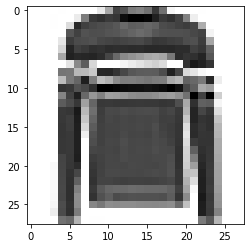

In [4]:
plt.imshow(trainX[5], cmap='gray_r')

In [5]:
def define_discriminator(in_shape=(28, 28, 1)):

    model = keras.Sequential()
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same', input_shape=in_shape))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Flatten())
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(1, activation='sigmoid'))

    opt = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(
        loss='binary_crossentropy',
        optimizer=opt,
        metrics=['accuracy'])

    return model

In [6]:
def define_generator(latent_dim):

    model = keras.Sequential()
    model.add(layers.Dense(units=128*7*7, input_dim=latent_dim))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Reshape((7, 7, 128)))

    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(1, (7, 7), activation='tanh', padding='same'))

    return model

In [7]:
def define_gan(generator, discriminator):

    discriminator.trainable = False

    model = keras.Sequential()
    model.add(generator)
    model.add(discriminator)

    opt = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

    model.compile(
        loss='binary_crossentropy',
        optimizer=opt
    )

    return model

In [8]:
def load_real_samples():

    (trainX, _), (_, _) = fashion_mnist.load_data()
    X = np.expand_dims(trainX, axis=-1).astype('float32')
    X = (X -127.5) / 127.5

    return X

In [9]:
def generate_real_samples(dataset, n_sample):

    ix = np.random.randint(0, dataset.shape[0], n_sample)
    X = dataset[ix]
    y = tf.ones(shape=(n_sample, 1))

    return X, y

In [10]:
def generate_latent_points(latent_dim, n_sample):

    x_input = tf.random.normal(shape=(n_sample, latent_dim))

    return x_input

In [11]:
def generate_fake_samples(generator, latent_dim, n_sample):

    x_input = generate_latent_points(latent_dim, n_sample)
    X = generator.predict(x_input)
    y = tf.zeros((n_sample, 1))

    return X, y

In [12]:
def train(G, D, GAN, dataset, latent_dim, n_epoch=100, n_batch=128):

    batch_per_epoch = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)

    D_LOSS = []
    G_LOSS = []
    for epoch in range(n_epoch):
        for iteration in range(batch_per_epoch):

            X_real, y_real = generate_real_samples(dataset, half_batch)
            D_loss1, _ = D.train_on_batch(X_real, y_real)
            X_Fake, y_fake = generate_fake_samples(G, latent_dim, half_batch)
            D_loss2, _ = D.train_on_batch(X_Fake, y_fake)

            X_gan = generate_latent_points(latent_dim, n_batch)
            y_gan = tf.ones((n_batch, 1))
            G_loss = GAN.train_on_batch(X_gan, y_gan)

            if iteration % 100 == 0:
                print('>%d, %d/%d, d_total=%.3f, g=%.3f' %
				    (epoch+1, iteration+1, batch_per_epoch, D_loss1+D_loss2, G_loss))
                generate_and_save_images(G, latent_dim)
                display.clear_output(wait=True)
            
                
            D_LOSS.append(D_loss1+D_loss2)
            G_LOSS.append(G_loss)
    
    G.save('Generator.h5')

    return D_LOSS, G_LOSS

In [13]:
def generate_and_save_images(G, latent_dim=100):

  z = generate_latent_points(latent_dim, 16)
  predictions = G(z, training=False)

  fig = plt.figure(figsize=(12, 12))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  # plt.savefig('fakeimage_fashionmnist/image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [14]:
latent_dim = 100
D = define_discriminator()
G = define_generator(latent_dim)
GAN = define_gan(G, D)

dataset = load_real_samples()
D_LOSS, G_LOSS = train(G, D, GAN, dataset, latent_dim)

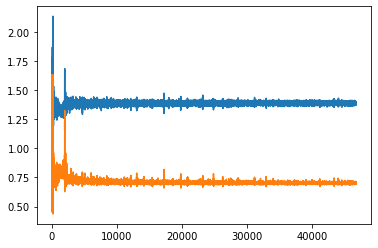

In [21]:
plt.plot(D_LOSS,)
plt.plot(G_LOSS,)
plt.show()

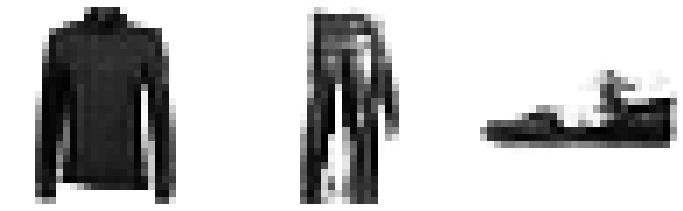

In [30]:
from tensorflow.keras.models import load_model

saved_generator = load_model('generator.h5')
batch_size = 3
noise = tf.random.normal(shape=(batch_size, 100))
imgs = saved_generator(noise, training=False)
# print(imgs.shape)
# print(type(imgs))
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))
for i, img in enumerate(imgs):
    axes[i].imshow(img.numpy().reshape((28,28)), cmap='gray_r')
    axes[i].axis('off')